<a href="https://colab.research.google.com/github/mahmud-nobe/Cluster-Membership/blob/master/DBSCAN/DBSCAN_3293_DR3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt


In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors


In [ ]:
!pip install astroquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 5.1 MB/s 
     |████████████████████████████████| 832 kB 48.2 MB/s 
     |████████████████████████████████| 48 kB 5.5 MB/s 
     |████████████████████████████████| 4.0 MB 56.8 MB/s 


In [ ]:

# import astroquery
import astropy.units as u
import astropy.coordinates as coord
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier



## Necessary Functions

### Loading the data

In [ ]:
def get_GAIA_data(name, radius = 1, table = 'gaiadr3.gaia_source', 
                  search = True, preprocess = True, *args, **kwargs):
    '''
    Collects the data from GAIA Archive for the given object by conesearch within
    a given radius from a given table. Then preprocessed the data to remove noisy
    data and to apply other cutoffs (i.e., |pm| < 20 mas/yr )
    '''

    if search:
        # conesearch using the object name and radius
        coordinate = coord.SkyCoord.from_name(name)
        print(f'Object Name: {name}')
        print('Co-ordinate', coordinate)

        radius = u.Quantity(radius, u.deg)
        Gaia.ROW_LIMIT = -1
        table = table
        j = Gaia.cone_search_async(coordinate, radius, table_name = table)
        r = j.get_results()

        all_stars = r.to_pandas()
        print(f'Total Raw Stars: {len(all_stars)}')

    #print(all_stars.head())

    ## plotting the skyplot 
    sns.set(rc={'figure.figsize':(8.7,6.27)})
    skyplot = sns.scatterplot(x='ra', y='dec', data = all_stars)
    skyplot.invert_xaxis()
    plt.title('Skyplot of GAIA data')
    plt.show()

    if preprocess:
        ## magnitude error
        ## del magnitude = - 2.5 log(del Flux / Flux)
        all_stars['g_mag_error'] = 2.5/np.log(10) / all_stars.phot_g_mean_flux_over_error

        mask = (all_stars.parallax_over_error >= 3) & (all_stars.pmra_error < 1) \
                & (all_stars.pmdec_error < 1) & (all_stars.ruwe < 1.4)

        all_stars = all_stars.loc[mask, :]
        print(f'Number of stars after applying noise filter: {len(all_stars)}')

        # calculating the distance from the parallax
        all_stars['distance_pc'] = 1/(all_stars.parallax*0.001)

        # positive parallax
        all_stars = all_stars[all_stars['parallax'] >= 0]

        # dropping rows with null values in required columns
        all_stars = all_stars[all_stars.loc[:, 'pmra'].notnull()]
        all_stars = all_stars[all_stars.loc[:, 'parallax'].notnull()]
        all_stars = all_stars[all_stars.loc[:, 'bp_rp'].notnull()]

        # defining proper motion (pm) range
        all_stars = all_stars[(abs(all_stars['pmra']) < 20) & (abs(all_stars['pmdec']) < 20)]

        # taking stars within 30' = 0.5 deg radius
        # all_stars = all_stars[all_stars['dist'] < (30/60)]
        print(f'Number of stars after applying other filters: {len(all_stars)}')
    
    return all_stars

In [ ]:
def get_normalized_feature(all_stars, feature_columns = ['pmra', 'pmdec', 'parallax']):
    # selecting the features
    features = all_stars.loc[:, feature_columns]
    features = features.dropna()

    # normalizing the features
    scaled_features = pd.DataFrame({})
    for column in features.columns:
        scaled_features[column] = (features[column] - np.median(features[column]))/np.std(features[column])
    
    return scaled_features

### Getting MNN and MSS Values

In [ ]:
def get_members(all_stars, scaled_features, eps, min_sample):
    db = DBSCAN(eps= eps,min_samples= min_sample).fit(scaled_features)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    all_stars['labels'] = labels
    all_stars['is_core'] = core_samples_mask

    member, non_member = all_stars[all_stars.labels == 0],\
                         all_stars[all_stars.labels == -1]
    return member, non_member


In [ ]:
def mean_nearest_neighbor(member_data, feature_columns = ['pmra', 'pmdec', 'parallax']):
    '''
    returns the average of the nearest neighbor distance for all the member stars
    ''' 

    # normalizing the features 
    scaled_member_features = get_normalized_feature(member_data, feature_columns)

    nn_model = NearestNeighbors(n_neighbors=2) # model to find 1st nearest neighbor

    nn_members = nn_model.fit(scaled_member_features)        # training the model using normalized dataset 

    nn_distances, nn_indices = nn_members.kneighbors(scaled_member_features) #[(distance, index of the 30th nearest neighbor)]

    mnn = np.mean(nn_distances[:, 1])

    return mnn


In [ ]:
def get_MSS_metric(member, non_member, epsilon = 1e-7, 
                   feature_columns = ['pmra', 'pmdec', 'parallax']):
    '''
    Returns the Modified Silhouttee Score for given member and non_member data
    '''
    if len(member) < 2 or len(non_member) < 2:
        return 0

    metric = np.zeros(len(feature_columns))
    for i in range(len(feature_columns)):
        feature_i = feature_columns[i]
        # (field_SD - member SD)/max(field_SD, member SD, epsilon) for each features
        metric[i] = (np.std(non_member[feature_i]) - np.std(member[feature_i])) \
                / max(np.std(member[feature_i]), np.std(non_member[feature_i]), epsilon)
    
    mss_metric = metric.mean()
    return mss_metric

In [ ]:
def compare_DBSCAN_parameters(all_stars, scaled_features, 
                              eps, min_samples):

    # running DBSCAN with all possible parameters
    mnn_values = np.full((len(eps), len(min_samples)), -1, dtype = 'float32')
    n_members = np.full((len(eps), len(min_samples)), -1, dtype = 'float32')
    mss_metrics = np.full((len(eps), len(min_samples)), -1, dtype = 'float32')

    for i in range(len(eps)):
        ep = eps[i]
        for j in range(len(min_samples)):
            min_sample = min_samples[j]

            member, non_member = get_members(all_stars, scaled_features, ep, min_sample)
            try:
                mnn_values[i,j] = mean_nearest_neighbor(member)
            # if there is any error comes up, we will continue the program by keeping -1 as the MNN value
            except: 
                pass
            mss_metrics[i,j] = get_MSS_metric(member, non_member)
            n_members[i,j] = len(member)

    # Creating a DataFrame with paramters and metrics
    model_parameters = pd.DataFrame({'eps': np.repeat(eps, len(min_samples)),
                        'min_sample': np.tile(min_samples, len(eps)),
                        'mnn': mnn_values.flatten(),
                        'mss': mss_metrics.flatten(), 
                        'n_member' : n_members.flatten()})
                      
    model_parameters = model_parameters[model_parameters.mnn > 0] # removing the rows where MNN is negative
    

    # Visualize the change in metric values
    plt.figure(figsize = (20,6))

    plt.subplot(131)
    sns.lineplot(x='eps', y='mnn', hue = 'min_sample', data = model_parameters, 
                 legend = 'full')

    plt.subplot(132)
    sns.lineplot(x='eps', y='mss', hue = 'min_sample', data = model_parameters, 
                 legend = 'full')

    plt.subplot(133)
    sns.lineplot(x='eps', y='n_member', hue = 'min_sample', data = model_parameters, 
                 legend = 'full')
    plt.show()

    return model_parameters

### Additional Function for Comparing with Cantat

In [ ]:
def get_cantat_data(data = 'member', clusters = None):
    if data == 'cluster':
        if clusters == None:
            cantat_data = Vizier(catalog = 'J/A+A/633/A99/table1', 
                             row_limit = -1).query_constraints()
        else:
            cantat_data = Vizier(catalog = 'J/A+A/633/A99/table1', 
                                row_limit = -1).query_constraints(Cluster = clusters)
        cantat_data = cantat_data[0].to_pandas()
        return cantat_data

    if data == 'member':
        if clusters == None:
            cantat_data = Vizier(catalog = 'J/A+A/633/A99/members', 
                             row_limit = -1).query_constraints()
        else:
            cantat_data = Vizier(catalog = 'J/A+A/633/A99/members', 
                                row_limit = -1).query_constraints(Cluster = clusters)
        cantat_data = cantat_data[0].to_pandas()

        # renaming the cantat table to match it with gaia_data
        cantat_data = cantat_data.rename(columns={'Source':'source_id',
                                                'Proba':'PMemb',
                                                'RA_ICRS': 'ra',
                                                'DE_ICRS': 'dec',
                                                'pmRA': 'pmra',
                                                'pmDE': 'pmdec',
                                                'Gmag': 'phot_g_mean_mag',
                                                'BP-RP': 'bp_rp',
                                                'Plx': 'parallax'})
        
        return cantat_data


In [ ]:
def get_rf_member(cluster_name):
    rf_data = pd.read_csv('https://raw.githubusercontent.com/mahmud-nobe/Cluster-Membership/master/all_possible_members.csv', index_col=0)
    rf_member = rf_data[rf_data.cluster == cluster_name]

    if len(rf_member) == 0:
        print(f'The cluster, {cluster_name}, is not present in RF data.\n')
    return rf_member

In [ ]:
def compare_with_cantat_rf(cluster_name, dbscan_member, cantat_member, rf_member, alpha = 1):

    concatenated = pd.concat([dbscan_member.assign(dataset='DBSCAN'), 
                            rf_member.assign(dataset = 'RF'),
                            cantat_member.assign(dataset='Cantat')])
    # concatenated.reset_index(drop=True)
    print(f'Cluster: {cluster_name}')
    print(concatenated.dataset.value_counts())
    print(f'Cantat (PMemb > 0.5): {sum(cantat_member.PMemb > 0.5)}')
    print('\n')

    # Distribution of parameters
    fig, axes = plt.subplots(1, 3, figsize=(20,6))
    fig.suptitle(f"Distribution of the Cantat and predicted Members of {cluster_name.replace('_', ' ')}")

    
    sns.histplot(data = concatenated.reset_index(), x = 'parallax', element='step',
                 hue='dataset', ax=axes[0], palette = 'Dark2', alpha = alpha)
    axes[0].set_title('Parallax Distribution')

    
    sns.histplot(data = concatenated.reset_index(), x = 'pmra', element='step',
                 hue='dataset', ax=axes[1], palette = 'Dark2', alpha = alpha)
    axes[1].set_title('pmra Distribution')

    sns.histplot(data = concatenated.reset_index(), x = 'pmdec', element='step',
                 hue='dataset', ax=axes[2], palette = 'Dark2', alpha = alpha)
    axes[2].set_title('pmdec Distribution')

    plt.show()


    fig, axes = plt.subplots(1, 3, figsize=(22,6))
    fig.suptitle(f"Predicted Members and Cantat Members of {cluster_name.replace('_', ' ')}")

    skyplot = sns.scatterplot(x='ra', y='dec', data=concatenated,
                    hue='dataset', ax=axes[0], palette = 'Dark2',
                    style='dataset')
    axes[0].set_title('Sky plot')

    # proper motion plot
    sns.scatterplot(x='pmra', y='pmdec', data=concatenated,
                    hue='dataset', ax=axes[1], palette = 'Dark2',
                    style='dataset')
    axes[1].set_title('Proper motion plot')

    cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
                    hue='dataset', ax=axes[2], palette = 'Dark2',
                    style='dataset')
    cmd.invert_yaxis()
    axes[2].set_title('CMD')

    plt.show()


## Running it for NGC 3293

Object Name: NGC_3293
Co-ordinate <SkyCoord (ICRS): (ra, dec) in deg
    (158.97, -58.231)>
INFO: Query finished. [astroquery.utils.tap.core]
Total Raw Stars: 122940


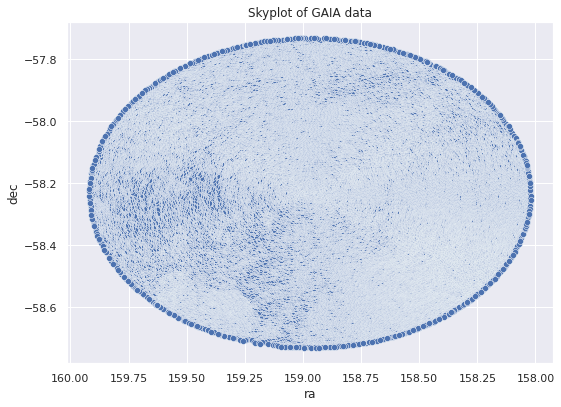

Number of stars after applying noise filter: 28855
Number of stars after applying other filters: 27552


In [ ]:
cluster_name = 'NGC_3293'
all_stars = get_GAIA_data(cluster_name, radius = 0.5)

In [ ]:
scaled_features = get_normalized_feature(all_stars)
scaled_features.head()

,pmra,pmdec,parallax
1,-0.241673,0.069100,-0.153596
3,-0.268633,0.097537,-0.232148
7,0.603483,-0.777410,-0.120795
18,-0.284100,0.142431,-0.137900
19,-0.260941,0.153271,-0.217148


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **

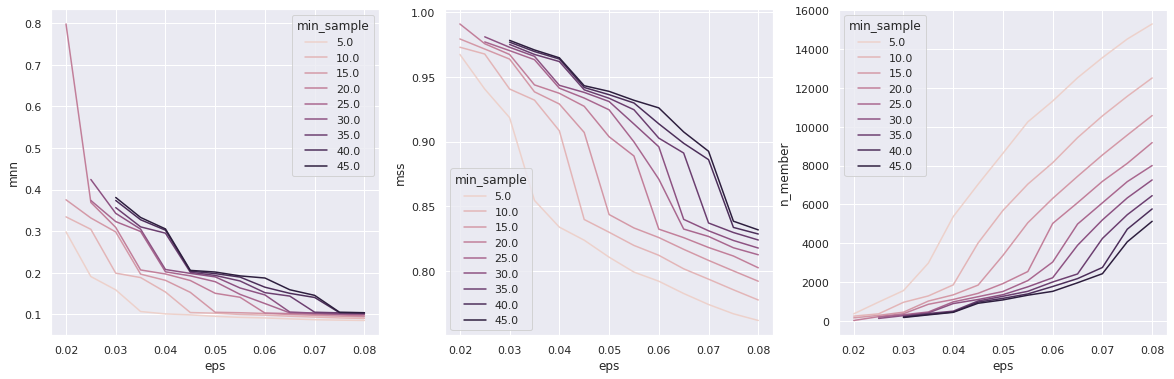

,eps,min_sample,mnn,mss,n_member
0,0.020,5.0,0.298324,0.967386,362.0
1,0.020,10.0,0.334510,0.972930,243.0
2,0.020,15.0,0.375570,0.979326,154.0
3,0.020,20.0,0.798383,0.990908,20.0
9,0.025,5.0,0.190897,0.940555,969.0


In [ ]:
eps = np.linspace(0.02,0.08,13) # you can modify the range
min_samples = np.linspace(5,45,9) # you can modify the range
model_parameters = compare_DBSCAN_parameters(all_stars, scaled_features, eps, min_samples)
model_parameters.head()

## Select the Hyperparameter

Using the above three plots, select the suitable value for eps and min_sample.

Note that, we want to have low value for MNN, high value for MSS and a reasonable number of members.

In [ ]:
best_eps =   0.06 # your code here
best_min_sample = 30 # your code here

member, non_member = get_members(all_stars, scaled_features, best_eps, best_min_sample)


In [ ]:
best_MSS = get_MSS_metric(member, non_member)
best_MNN = mean_nearest_neighbor(member)
best_n_member = len(member)
print(f'Mean Nearest Neighbor distance: {best_MNN:0.2f}, \n\
        Modified Silhouette Score: {best_MSS:0.2f}, \n\
        Number of Member: {best_n_member}')

Mean Nearest Neighbor distance: 0.15, 
        Modified Silhouette Score: 0.90, 
        Number of Member: 2222


### Compare with Cantat and RF

In [ ]:
cantat_member = get_cantat_data(clusters = cluster_name)

In [ ]:
rf_member = get_rf_member(cluster_name)

Cluster: NGC_3293
DBSCAN    2222
RF        1706
Cantat     657
Name: dataset, dtype: int64
Cantat (PMemb > 0.5): 370




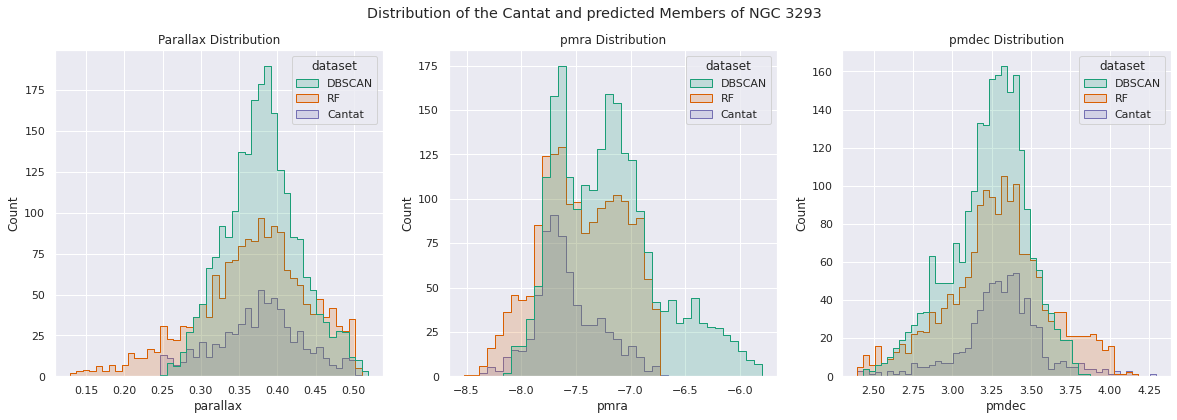

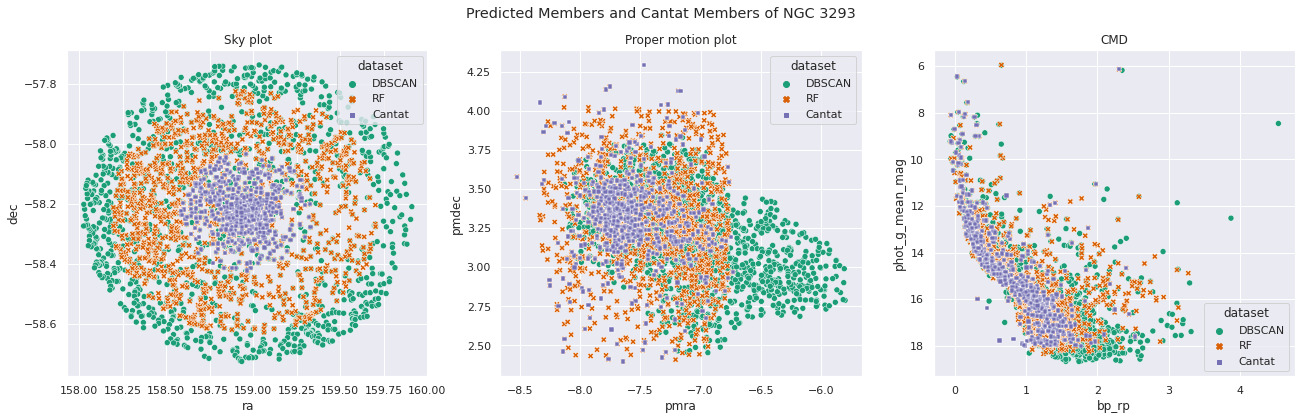

In [ ]:
compare_with_cantat_rf(cluster_name, member, cantat_member, rf_member, alpha = 0.2)

## Saving the members as CSV

Once you are satisfied with your member group, you can save and download it, if you wish.

In [ ]:
# for downloading file
from google.colab import files
member.to_csv(f'{cluster_name}_dbscan_member.csv') # saved it in a csv

Wait 1-2 minute before running the next line to ensure that the full member data converts to CSV.

In [ ]:
files.download(f'{cluster_name}_dbscan_member.csv') # download in local computer

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>